In [1]:
# !kaggle datasets download -d andrewmvd/car-plate-detection

In [2]:
# !unzip car-plate-detection.zip

In [3]:
!pip install imutils
!pip install easyocr

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from glob import glob
from shutil import copy
import shutil
import xml.etree.ElementTree as xet
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Import VGG16, ResNet50, and InceptionV3 from keras.applications

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import easyocr
import imutils


In [5]:
# Directories
dataset_path = '/content'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)

    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

In [7]:
# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata.head(3)


,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/images/Cars0.png,226,419,125,173,500,268
1,/content/images/Cars1.png,134,262,128,160,400,248
2,/content/images/Cars2.png,229,270,176,193,400,400


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size = 0.1, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}

      len(test) = {len(test)}
''')


      len(train) = 389

      len(test) = 44



In [9]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images if they don't exist
    os.makedirs(labels_path, exist_ok=True) # Use exist_ok=True to avoid error if directory exists
    os.makedirs(images_path, exist_ok=True) # Use exist_ok=True to avoid error if directory exists

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [10]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [11]:
train_path="/content/datasets/cars_license_plate_new/train"
test_path="/content/datasets/cars_license_plate_new/test"

In [12]:
train_ds=image_dataset_from_directory(
    train_path,
    image_size=(256,256),
    batch_size=32,
    labels="inferred"
    ,label_mode="int")

test_ds=image_dataset_from_directory(
    test_path,
    image_size=(256,256),
    batch_size=32,
    labels="inferred"
    ,label_mode="int")

Found 389 files belonging to 2 classes.
Found 44 files belonging to 2 classes.


In [13]:
train_ds.class_names

['images', 'labels']

In [14]:
!pip install ultralytics

In [15]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/config.yaml", epochs=50, imgsz=640)

Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/config.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /content/datasets/cars_license_plate_new/train/labels.cache... 389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 389/389 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/cars_license_plate_new/test/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.47G      1.489      2.968      1.302         10        640: 100%|██████████| 25/25 [00:15<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all         44         44      0.383      0.591      0.576      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.3G      1.475      1.979      1.229         15        640: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         44         44          1      0.356       0.61      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.3G      1.536      1.933       1.26         10        640: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         44         44      0.648      0.477      0.514      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.31G      1.444      1.793       1.28          9        640: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         44         44      0.844      0.613      0.679      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.3G      1.515      1.642      1.357         10        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


                   all         44         44      0.891      0.523      0.645      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.3G      1.535      1.593      1.379         10        640: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         44         44      0.156      0.519       0.13     0.0515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.3G      1.434      1.418      1.257          6        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         44         44      0.518      0.562      0.517      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.3G      1.512      1.348       1.29         10        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         44         44      0.649      0.523      0.607      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.3G      1.421      1.268       1.25          7        640: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         44         44      0.641      0.455      0.564      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.3G      1.369      1.198      1.204          8        640: 100%|██████████| 25/25 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         44         44      0.772      0.705      0.784      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.3G      1.419      1.134      1.255          8        640: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         44         44      0.843      0.818      0.878      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.3G       1.38      1.073      1.227         13        640: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         44         44      0.907      0.841       0.93      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.3G      1.385      1.057      1.236         11        640: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         44         44      0.906      0.841      0.896      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.3G      1.366      1.049      1.206          8        640: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         44         44      0.946      0.795      0.882      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.3G      1.461      1.052      1.254          7        640: 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         44         44      0.966      0.818      0.934       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.3G      1.381     0.9929      1.218         10        640: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         44         44      0.936      0.841      0.934      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.3G      1.357     0.9338        1.2         10        640: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         44         44      0.972      0.886      0.962      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.3G      1.276     0.9376      1.163         10        640: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         44         44      0.887       0.89      0.943      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.3G      1.314     0.9135      1.198         12        640: 100%|██████████| 25/25 [00:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         44         44      0.925      0.818      0.903      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.3G      1.278      0.911      1.168          8        640: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         44         44      0.969      0.841      0.922      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.29G      1.228     0.8529      1.157          9        640: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         44         44      0.886      0.864      0.919      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.3G      1.289     0.8461      1.178          7        640: 100%|██████████| 25/25 [00:11<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         44         44      0.974       0.84      0.924      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.3G      1.205     0.8215      1.115         11        640: 100%|██████████| 25/25 [00:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         44         44      0.947      0.886      0.924      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.3G      1.221     0.7848      1.139          6        640: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         44         44      0.927      0.865      0.912      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.29G      1.256     0.8507      1.139          6        640: 100%|██████████| 25/25 [00:11<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         44         44      0.973      0.813       0.89      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.3G      1.204     0.7837      1.137         11        640: 100%|██████████| 25/25 [00:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         44         44      0.966      0.818      0.907      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.3G      1.184     0.7829      1.133          8        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         44         44      0.905      0.863      0.908      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.3G       1.21     0.7997      1.137         12        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         44         44      0.959      0.886      0.937      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.3G      1.214     0.7623      1.152         13        640: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         44         44      0.911      0.932      0.924      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.3G      1.164       0.72      1.126          9        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         44         44      0.867      0.909      0.929      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.3G      1.208     0.7311      1.148          9        640: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         44         44      0.943      0.818      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.3G      1.216      0.722       1.14          7        640: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         44         44      0.962      0.886      0.936      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.3G      1.138     0.7087      1.113         14        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         44         44      0.975       0.88      0.935      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.3G      1.192      0.715      1.139          7        640: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         44         44       0.95      0.872      0.924      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.3G      1.158     0.6947      1.109          7        640: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         44         44      0.929      0.899      0.932       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.3G      1.127     0.6709      1.096          7        640: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         44      0.928      0.885      0.924      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.3G      1.106      0.681      1.095         10        640: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         44         44      0.925      0.909      0.931      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.3G      1.165     0.6817      1.121         10        640: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         44         44      0.925      0.909      0.934      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.3G      1.095     0.6473      1.096         10        640: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         44         44      0.891      0.926      0.943      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.3G      1.075     0.6451      1.105          9        640: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         44         44      0.947      0.909      0.945        0.6


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.43G      1.029      0.648      1.062          5        640: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         44         44      0.994      0.864      0.949      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.3G      1.101      0.639      1.083          5        640: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         44         44      0.972      0.886      0.947      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.3G      1.048     0.6176      1.065          5        640: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         44         44      0.925      0.909      0.947      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.3G      1.015     0.5996      1.063          5        640: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         44         44      0.872      0.929      0.946      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.29G      1.046     0.5771      1.066          5        640: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         44         44      0.974      0.838       0.94      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.3G     0.9923     0.5698      1.042          5        640: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         44         44      0.946      0.864      0.936      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.3G     0.9863     0.5718       1.05          5        640: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         44         44      0.919      0.886      0.948      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.3G     0.9924     0.5645      1.057          5        640: 100%|██████████| 25/25 [00:08<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         44         44      0.924      0.909      0.949      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.29G     0.9544     0.5442      1.059          5        640: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         44         44      0.927      0.909      0.949      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.3G     0.9546     0.5429      1.043          5        640: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         44         44      0.929      0.886       0.95      0.634



50 epochs completed in 0.188 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.2.70 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


                   all         44         44      0.929      0.886      0.949      0.634
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train10


In [16]:
# Load the fine turned model
License_plate_model = YOLO('/content/runs/detect/train9/weights/best.pt')

In [17]:
# creating a random number to obtain random image from the dataset

ran_num = np.random.randint(0, len(test_ds))


0: 352x640 1 Licence_Plate, 64.9ms
Speed: 1.5ms preprocess, 64.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


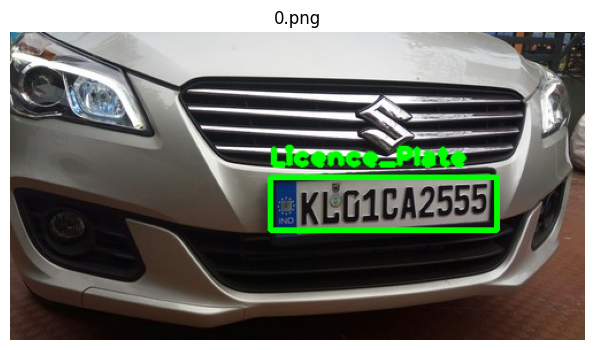

In [18]:
# Function for visualising bounding box on license plate
import cv2


import matplotlib.pyplot as plt
img_path =f"/content/datasets/cars_license_plate_new/train/images/Cars{ran_num}.png"


def show_bbox(img_path):

    image = cv2.imread(img_path)

    results = License_plate_model(image)[0]

    threshold = 0.5

    for result in results.boxes.data.tolist():
        x1,y1,x2,y2, score, class_id = result

        if score>=threshold:
            # Draw bounding box
            cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),4)

            # Write label text above the bounding box
            cv2.putText(image,results.names[int(class_id)],(int(x1),int(y1-10)),
                        fontFace = cv2.FONT_HERSHEY_PLAIN, fontScale= 1.5, color=(0,255,0),
                        thickness=3, lineType=cv2.LINE_AA)

    # Convert the image from BGR to RGB format for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes and labels using Matplotlib
    plt.figure(figsize=(10, 4))
    plt.imshow(image_rgb)
    plt.title(f'{ran_num}.png')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

show_bbox(img_path)

In [22]:

def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
         # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    bfilter = cv2.bilateralFilter(gray_image, 45, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) #Edge detection
    plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

    #contour
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contourss = imutils.grab_contours(keypoints)
    contours = sorted(contourss, key=cv2.contourArea, reverse=True)[:10]



    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 5, True)
        if len(approx) == 4:
            location = approx
            break
    print(location)

   # Check if any valid contour was found
    if location is None:
        print("No valid contour found.")
        return  # Exit the function if no contour is found

    #create window empty and draw Plate
    mask = np.zeros(gray_image.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)


    # coordinate rectangle
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = new_image[x1:x2+1, y1:y2+1]



    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)

    text = result[0][-2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(image, text=text, org=(approx[0][0][0]-120, approx[1][0][1]+65), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(image, (approx[0][0]), (approx[2][0]), (0,255,0),3)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))




    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

[[[417 123]]

 [[249 130]]

 [[249 175]]

 [[415 164]]]
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

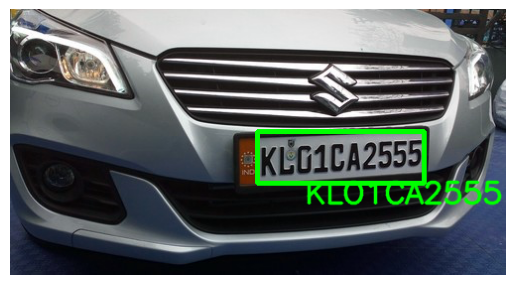

In [23]:
predict_and_plot(img_path)